In [1]:
from utilities import wrappers,dataset_utils
from preprocessing import pipelines,PDBio,PDB_processing,protein_chemistry,sequence_utils
import tensorflow as tf
import keras.backend as K
import numpy as np
from visualizations import show_3d_filters,show_3d_neighborhoods,weight_logo_3d
import predict_features
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

def flatten_list(nested_list):
    out = []
    for list_ in nested_list:
        out+= list_
    return np.array(out)

def get_gradient(model, input, residue_index, layer = 'SCAN_filter_activity_atom'):
    gradient0 = K.gradients(
        model.model.get_layer('attention_layer').output[0][:, residue_index, 0],
        model.model.get_layer(layer).output
    )

    gradient1 = K.gradients(
        model.model.get_layer('attention_layer').output[0][:, residue_index, 1],
        model.model.get_layer(layer).output
    )
    gradient = gradient0 + gradient1
    activation = model.model.get_layer(layer).output

    sess = K.get_session()
    output = sess.run(gradient +[activation], feed_dict=dict(
        [(input_tensor,input_value[np.newaxis])  for input_tensor,input_value in zip(model.model.inputs, input) ]
    )
    )
    test_gradient = output[1][0] - output[0][0]
    test_activation = output[-1][0]
    return test_gradient,test_activation

sg = weight_logo_3d.make_sphere_geometry(30)

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/frame

In [2]:

model_name = 'ScanNet_PAI_noMSA_0'
dataset_name = 'BCE_fold1'
pdbid = '7jvb_A'
biounit = False

list_origins = dataset_utils.read_labels('datasets/BCE/labels_fold1.txt')[0]
filter_specificities = show_3d_filters.calculate_filter_specificities(
    model_name,
    dataset_name = dataset_name,
    dataset_origins = list_origins,
    biounit=False,
    ncores=4,
    only_atom=False
)



file,chainid = PDBio.getPDB(pdbid,biounit=biounit)
chain = PDBio.load_chains(file=file,chain_ids=chainid)[1]
resnumber = list(PDB_processing.get_PDB_indices(chain) )
sequence,_,_,atomids,_ = PDB_processing.process_chain(chain)
atomids = flatten_list(atomids)
nresidues = len(resnumber)
natoms = len(atomids)
model = wrappers.load_model('models/%s'%model_name,Lmax=nresidues)
pipeline = pipelines.ScanNetPipeline(Lmax_aa=nresidues,padded=True)


inputs = pipeline.process_example(chain_obj=chain)[0]

dictionary_binding = predict_features.predict_features(pdbid,model=model_name,
                                                       layer=None )
dictionary_attention = predict_features.predict_features(pdbid,model=model_name,
                                                       layer='attention_layer' )


vector_binding = np.array(list(dictionary_binding.values()))
vector_attention = np.array(list(dictionary_attention.values()))

Parsing /Users/jerometubiana/PDB/pdb7jvb.ent





/Users/jerometubiana/Documents/GitHub/ScanNet/utilities/dataset_utils.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_labels = np.array(list_labels)
/Users/jerometubiana/Documents/GitHub/ScanNet/utilities/dataset_utils.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  list_resids = np.array(list_resids)




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
point_clouds_atom (InputLayer)  (None, 2134, 3)      0                                            
__________________________________________________________________________________________________
frame_indices_atom (InputLayer) (None, 1746, 3)      0                                            
__________________________________________________________________________________________________
masked_point_clouds_atom (Maski (None, 2134, 3)      0           point_clouds_atom[0][0]          
__________________________________________________________________________________________________
masked_frame_indices_atom (Mask (None, 174

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numba/typed/typedlist.py:66: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'item' of function 'impl_append.<locals>.impl'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/anaconda3/envs/py36/lib/python3.6/site-packages/numba/typed/listobject.py", line 597:

    def impl(l, item):
    ^

  l.append(item)
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'item' of function '_append'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/an

Predicting binding sites from pdb structures with ScanNet_interface
Parsing /Users/jerometubiana/PDB/pdb7jvb.ent
List of inputs:
['7jvb_0_A']
Loading model ScanNet_interface
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
point_clouds_atom (InputLayer)  (None, 2134, 3)      0                                            
__________________________________________________________________________________________________
frame_indices_atom (InputLayer) (None, 1746, 3)      0                                            
__________________________________________________________________________________________________
masked_point_clouds_atom (Maski (None, 2134, 3)      0           point_clouds_atom[0][0]          
__________________________________________________________________________________________________
masked_frame_indi

Generating groups...
Grouped 1 examples in 1 groups
Grouping and padding...
Performing prediction...
1/1 [==============================] - 1s 793ms/step
Ungrouping and unpadding...
prediction done!
Predicting binding sites from pdb structures with ScanNet_interface
Parsing /Users/jerometubiana/PDB/pdb7jvb.ent
List of inputs:
['7jvb_0_A']
Loading model ScanNet_interface
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
point_clouds_atom (InputLayer)  (None, 2134, 3)      0                                            
__________________________________________________________________________________________________
frame_indices_atom (InputLayer) (None, 1746, 3)      0                                            
__________________________________________________________________________________________________
masked_point_clo

Generating groups...
Grouped 1 examples in 1 groups
Grouping and padding...
Performing prediction...
1/1 [==============================] - 1s 798ms/step
Ungrouping and unpadding...
prediction done!
Warning, attention coeffs are flipped


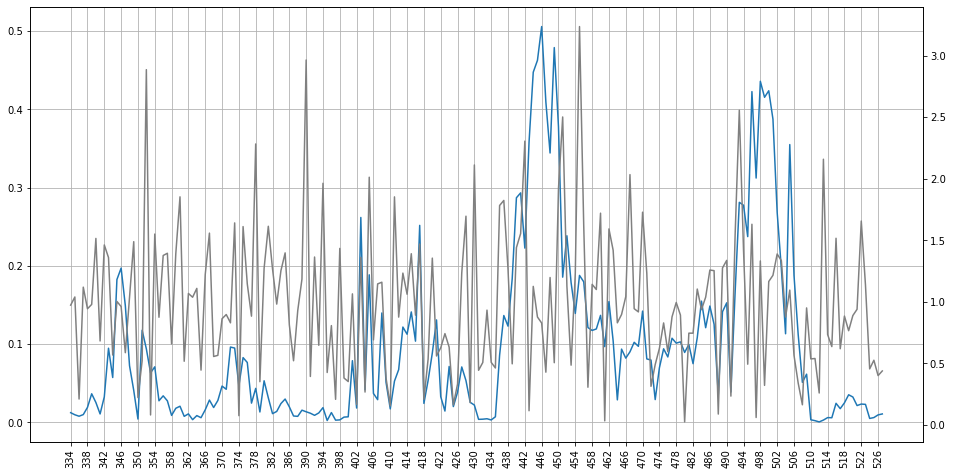

In [3]:

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(vector_binding)
ax2 = ax.twinx()
ax2.plot(vector_attention, c='gray')
ax.set_xticks(np.arange(nresidues)[::4])
ax.set_xticklabels(resnumber[::4], rotation=90)
ax.grid()
plt.show()


In [53]:
modelid = 0
chainid = 'A'
residue = 417

print ('Residue: %s%s, binding: %.3f, attention: %.3f'%(
residue,
sequence[resnumber.index(residue)],
dictionary_binding[(modelid,chainid,residue)],
dictionary_attention[(modelid,chainid,residue)],    
) 
      )


residue_index = resnumber.index(residue)

Residue: 417K, binding: 0.252, attention: 1.468


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


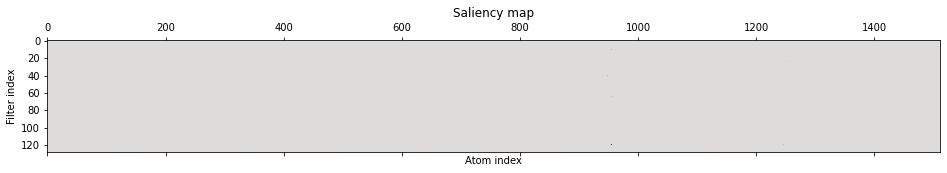

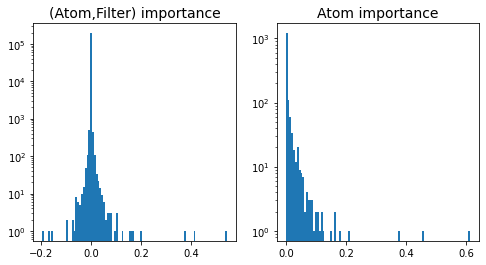

455 CD1 119 0.54047835
491 N 117 0.41363844
493 OE1 119 0.37670958
453 O 43 0.19730543
455 CD1 64 0.17299509
493 N 119 0.15970834
415 CG2 64 0.15620513
417 NZ 64 0.12385975
455 CD1 46 0.10351321
493 CD 24 0.102931134
456 CG 119 0.10242688
491 N 100 -0.15572345
455 N 40 -0.17212613
455 CD1 10 -0.19442242


In [54]:
gradient,activation = get_gradient(model, inputs, residue_index, 
                                   layer = 'SCAN_filter_activity_atom'
                                 )
try:
    conditional_activity = filter_specificities['filter_conditional_activity_atom']['cond_median']
except:
    conditional_activity = np.array([np.median(activation[:natoms][atomids==k], axis=0) for k in range(38)])
baseline_activation = conditional_activity[atomids,:]
saliency = (gradient[:natoms] * (activation[:natoms] - baseline_activation ) )

plt.matshow(saliency.T, aspect='auto',
            cmap='coolwarm', vmax=0.8 * np.abs(saliency).max(), vmin=- 0.8 * np.abs(saliency).max())
plt.title('Saliency map')
plt.xlabel('Atom index')
plt.ylabel('Filter index')
plt.show()


fig, ax = plt.subplots(ncols=2,figsize=(8,4))

ax[0].hist(saliency.flatten(), bins=100, log=True)
atom_importance = np.sqrt((saliency ** 2).sum(-1))
ax[0].set_title('(Atom,Filter) importance',fontsize=14)
ax[1].hist(atom_importance, bins=100, log=True)
ax[1].set_title('Atom importance',fontsize=14)
plt.show()


explaining_atom_pairs = np.nonzero(np.abs(saliency) >= 0.1)
explanation_values = saliency[explaining_atom_pairs[0], explaining_atom_pairs[1]]

order = np.argsort(explanation_values)[::-1]

explaining_resids = [resnumber[x] for x in inputs[6][explaining_atom_pairs[0], 0]]
explaining_atomids = [protein_chemistry.list_atoms[x] for x in atomids[explaining_atom_pairs[0]]]

nexplanations = len(explaining_resids)

for n in order:
    print(explaining_resids[n], explaining_atomids[n], explaining_atom_pairs[1][n], explanation_values[n])




In [ ]:
explaining_residue = 455
explaining_atom = 'CD1'
explaining_filter =119


atom_positions,atom_types,atom_bonds = show_3d_neighborhoods.get_neighborhood(
        pdb = pdbid[:4],
        model = modelid,
        chain = chainid,
        resnumber = explaining_residue,
        atom = explaining_atom,
        assembly=False,
        biounit=biounit,
)


list_objects = show_3d_neighborhoods.show_atoms(atom_positions,atom_types,atom_bonds,render=False,
                                               radius_scale = 0.15)

renderer = show_3d_filters.plot_atomic_filter(filter_specificities,
                                                 explaining_filter,
                                                  y_offset = 0.25,
                                                 sg=sg,
                                                 list_additional_objects=list_objects,
                                                threshold1=0.33);
display(renderer)

Parsing /Users/jerometubiana/PDB/pdb7jvb.ent


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


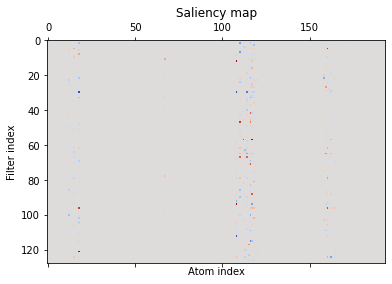

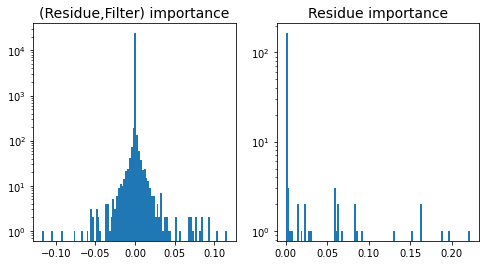

RESID: 442 D Filter: 94, Activity: 2.01, Saliency 0.12 
RESID: 451 Y Filter: 57, Activity: 0.88, Saliency 0.10 
RESID: 442 D Filter: 30, Activity: 1.88, Saliency -0.11 
RESID: 352 A Filter: 30, Activity: 0.96, Saliency -0.12 


In [48]:
gradient,activation = get_gradient(model, inputs, residue_index, 
                                   layer = 'SCAN_filter_activity_aa'
                                 )

seqnum = sequence_utils.seq2num(sequence)[0]


try:
    conditional_activity = filter_specificities['filter_conditional_activity_aa']['cond_median']
except:
    conditional_activity = np.array([np.median(activation[seqnum==k], axis=0) for k in range(20)])
baseline_activation = conditional_activity[seqnum,:]
saliency = (gradient * (activation - baseline_activation ) )



plt.matshow(saliency.T, aspect='auto',
            cmap='coolwarm', vmax=0.8 * np.abs(saliency).max(), vmin=- 0.8 * np.abs(saliency).max())
plt.title('Saliency map')
plt.xlabel('Atom index')
plt.ylabel('Filter index')
plt.show()


fig, ax = plt.subplots(ncols=2,figsize=(8,4))

ax[0].hist(saliency.flatten(), bins=100, log=True)
residue_importance = np.sqrt((saliency ** 2).sum(-1))
ax[0].set_title('(Residue,Filter) importance',fontsize=14)
ax[1].hist(residue_importance, bins=100, log=True)
ax[1].set_title('Residue importance',fontsize=14)
plt.show()


explaining_residue_pairs = np.nonzero(np.abs(saliency) >= 0.1)
explanation_saliencies = saliency[explaining_residue_pairs[0], explaining_residue_pairs[1]]
explanation_values = activation[explaining_residue_pairs[0], explaining_residue_pairs[1]]

order = np.argsort(explanation_saliencies)[::-1]

explaining_resids = [resnumber[x] for x in explaining_residue_pairs[0] ]
explaining_residue = [sequence[x] for x in explaining_residue_pairs[0] ]

nexplanations = len(explaining_resids)

for n in order:
    print('RESID: %s %s Filter: %s, Activity: %.2f, Saliency %.2f ' % (explaining_resids[n], explaining_residue[n], explaining_residue_pairs[1][n], 
          explanation_values[n], explanation_saliencies[n]) )





In [49]:
explaining_residue = 442
explaining_atom = None
explaining_filter = 94


atom_positions,atom_types,atom_bonds = show_3d_neighborhoods.get_neighborhood(
        pdb = pdbid[:4],
        model = modelid,
        chain = chainid,
        resnumber = explaining_residue,
        atom = explaining_atom,
        assembly=False,
        biounit=biounit,
        Kmax=9*16
)


list_objects = show_3d_neighborhoods.show_atoms(atom_positions,atom_types,atom_bonds,render=False)

renderer = show_3d_filters.plot_aminoacid_filter(filter_specificities,
                                                 explaining_filter,
                                                 sg=sg,
                                                 list_additional_objects=list_objects,
                                                threshold1=0.33);
display(renderer)

Parsing /Users/jerometubiana/PDB/pdb7jvb.ent


Renderer(camera=PerspectiveCamera(position=(19.200000000000003, 12.0, 19.200000000000003), projectionMatrix=(1…

<Figure size 144x576 with 0 Axes>

<Figure size 144x576 with 0 Axes>

<Figure size 144x576 with 0 Axes>

<Figure size 144x576 with 0 Axes>

<Figure size 144x576 with 0 Axes>

<Figure size 144x576 with 0 Axes>

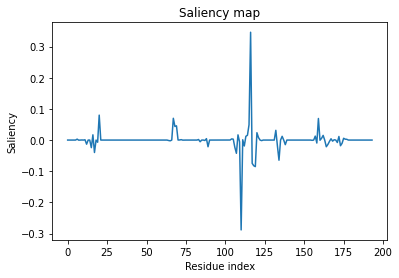

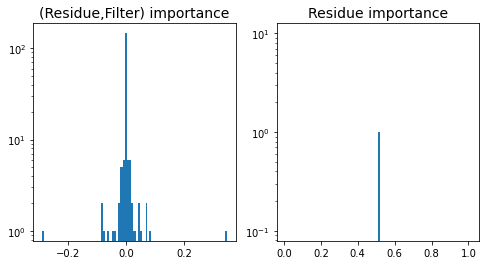

RESID: 450 N Saliency 0.35 
RESID: 444 K Saliency -0.29 


In [52]:
gradient,activation = get_gradient(model, inputs, residue_index, 
                                   layer = 'attributes_aa'
                                 )

seqnum = sequence_utils.seq2num(sequence)[0]

baseline_activation = np.array([1] + 19*[0])[np.newaxis]

saliency = (gradient * (activation - baseline_activation ) ).sum(-1)



plt.plot(saliency)
plt.title('Saliency map')
plt.xlabel('Residue index')
plt.ylabel('Saliency')
plt.show()


fig, ax = plt.subplots(ncols=2,figsize=(8,4))

ax[0].hist(saliency.flatten(), bins=100, log=True)
residue_importance = np.sqrt((saliency ** 2).sum(-1))
ax[0].set_title('(Residue,Filter) importance',fontsize=14)
ax[1].hist(residue_importance, bins=100, log=True)
ax[1].set_title('Residue importance',fontsize=14)
plt.show()


explaining_residues = np.abs(saliency)>0.2
explanation_saliencies = saliency[explaining_residues]

order = np.argsort(explanation_saliencies)[::-1]

explaining_resids = [resnumber[x] for x in explaining_residue_pairs[0] ]
explaining_residue = [sequence[x] for x in explaining_residue_pairs[0] ]

nexplanations = len(explaining_resids)

for n in order:
    print('RESID: %s %s Saliency %.2f ' % (explaining_resids[n], explaining_residue[n], explanation_saliencies[n]) )






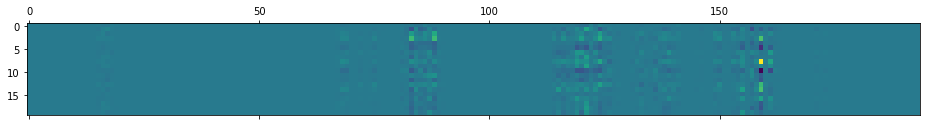

In [35]:
plt.matshow(gradient.T)